**0. Imports**

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

**1. Define PDF Function**

In [112]:
# Function to compute intensity values
def gaussian_pdf(rt, mz_array, center_rt, center_mz, sigma_rt, sigma_mz, amplitude=1):
    rt_gauss = np.exp(-0.5 * ((rt - center_rt) / sigma_rt) ** 2)
    mz_gauss = np.exp(-0.5 * ((mz_array - center_mz) / sigma_mz) ** 2)
    intensity = amplitude * rt_gauss * mz_gauss
    return intensity

**2. Define Gaussian Creation Function**

In [ ]:
def create_grid_with_gaussian(rt_axis: pd.Series, mz_axis: pd.Series, peak_params: list):
    # Initialize empty list to store intensity values
    intensities = []

    # Loop through each rt value and the corresponding mz values
    for rt_val, mz_array in zip(rt_axis, mz_axis):
        # Convert mz array
        mz_array = np.array(mz_array)

        # Initialize intensity for this particular rt value (list of zeros)
        row_intensity = np.zeros_like(mz_array, dtype=float)

        # Compute intensity for each peak and accumulate it
        for peak in peak_params:
            rt_center = peak["rt_center"]
            mz_center = peak["mz_center"]
            rt_sigma = peak["rt_sigma"]
            mz_sigma = peak["mz_sigma"]
            amplitude = peak["amplitude"]
        
            # Apply the Gaussian function for the current peak
            peak_intensity = gaussian_pdf(rt_val, mz_array, rt_center, mz_center, rt_sigma, mz_sigma, amplitude)

            # Add the peak intensities to the row's intensity
            row_intensity += peak_intensity  # Sum intensities for this mz value

        # Append the summed intensities for this row (as a list of values)
        intensities.append(row_intensity.tolist())  # Convert to list

    # Convert the intensities list to a DataFrame, with each rt value corresponding to a row
    intensity_df = pd.DataFrame({
        "rt": rt_axis,
        "mz": mz_axis,
        "intensities": intensities
    })

    return intensity_df


**3. Import Grid**

In [114]:
# Import JSON Grid
grid = pd.read_json("grid.json")

# Define Axes
rt_axis = grid["rt"]
mz_axis = grid["mz"]

grid.head()

,rt,mz
0,10.000000,"[150.0, 150.0177835251, 150.0361831772, 150.04..."
1,10.046676,"[150.0, 149.9986225977, 150.0228173071, 150.01..."
2,10.098219,"[150.0, 150.0017192089, 150.029757481, 150.042..."
3,10.134902,"[150.0, 149.9997931667, 150.0282730933, 150.04..."
4,10.166766,"[150.0, 150.0040958935, 150.0066260195, 150.02..."


**4. Define Gaussians**

In [115]:
# Define peak height
peak_height = 25067.0

# Define peak params
peak_params = [
    {"rt_center": 11.5, "mz_center": 152.1, "rt_sigma": 0.1, "mz_sigma": 0.03, "amplitude": 10000},
    {"rt_center": 12.0, "mz_center": 153.0, "rt_sigma": 0.15, "mz_sigma": 0.025, "amplitude": 25000},
    {"rt_center": 13.0, "mz_center": 154.5, "rt_sigma": 0.2, "mz_sigma": 0.04, "amplitude": 18000},
    # Adding more is possible
]

**5. Generate Gaussians Inside Grid**

In [116]:
grid_gaussians = create_grid_with_gaussian(rt_axis=rt_axis, 
                                           mz_axis=mz_axis, 
                                           peak_params=peak_params)

grid_gaussians.head()

,rt,mz,intensities
0,10.000000,"[150.0, 150.0177835251, 150.0361831772, 150.04...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,10.046676,"[150.0, 149.9986225977, 150.0228173071, 150.01...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,10.098219,"[150.0, 150.0017192089, 150.029757481, 150.042...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,10.134902,"[150.0, 149.9997931667, 150.0282730933, 150.04...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,10.166766,"[150.0, 150.0040958935, 150.0066260195, 150.02...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


**6. Plot Results**

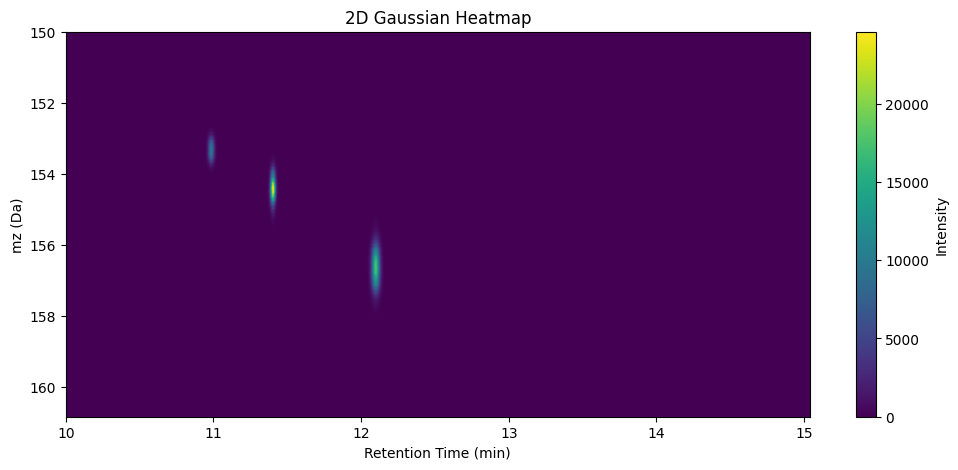

In [118]:
def plot_heatmap_from_irregular_data(df, title="2D Gaussian Heatmap", zoom=False, mz_points=1000):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.interpolate import interp1d

    # Step 1: Get rt values (as X-axis)
    rt_values = df["rt"].values

    # Step 2: Define a common mz grid over full range (Y-axis)
    all_mz = np.concatenate(df["mz"].values)
    mz_min, mz_max = all_mz.min(), all_mz.max()
    common_mz = np.linspace(mz_min, mz_max, mz_points)

    # Step 3: Interpolate each mz-intensity pair to the common mz grid
    interpolated_matrix = []
    for mz, intensity in zip(df["mz"], df["intensities"]):
        mz = np.array(mz)
        intensity = np.array(intensity)

        # Interpolate intensities onto the common mz grid
        interp = interp1d(mz, intensity, kind='linear', bounds_error=False, fill_value=0)
        interpolated_intensity = interp(common_mz)
        interpolated_matrix.append(interpolated_intensity)

    # Step 4: Convert list of arrays to a 2D numpy array
    intensity_matrix = np.array(interpolated_matrix)

    # Step 5: Plot the heatmap
    plt.figure(figsize=(12, 5))
    plt.imshow(intensity_matrix,
               extent=[rt_values[0], rt_values[-1], common_mz[-1], common_mz[0]],
               aspect='auto',
               cmap='viridis')
    plt.colorbar(label='Intensity')
    plt.xlabel('Retention Time (min)')
    plt.ylabel('mz (Da)')
    plt.title(title)

    # Optional zoom
    if zoom:
        plt.xlim(zoom.get('xlim', (rt_values[0], rt_values[-1])))
        plt.ylim(zoom.get('ylim', (common_mz[0], common_mz[-1])))

    plt.show()

plot_heatmap_from_irregular_data(df=grid_gaussians)